### This project aims to analyze user sentiments and categorize them as positive, negative, or neutral.

Rationale: In today's market, customer reviews significantly influence purchasing decisions. For instance, Google prioritizes websites with positive feedback from users. Thus, pinpointing negative reviews becomes crucial to ensure they don't adversely impact product marketing.

In [46]:

# importing required libraries

import pandas as pd # for analysing the data
import numpy as np # for mathematical collections on arrays
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import sklearn as skl # for machine learning algorithms

import nltk # natural language toolkit
# snowball represents a ball type in which all similar words like cared, caring etc and 
# stemmer means all words come under a common stem i.e care in this example.
stemmer=nltk.SnowballStemmer(language="english") 
nltk.download("stopwords")
from nltk.corpus import stopwords # corpus means single collection and corpora means multiple collection of data
stopwords=set(stopwords.words("english")) # make a set of particular english words 


import string # used for purpose of cleaning
import re # for regular expression
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
#pip install contractions


In [48]:
import contractions

###  Get the Data

In [49]:
data_main=pd.read_csv("reviews_data_dump/reviews_badminton/data.csv")


In [50]:
data_main

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [51]:
data_main.columns = ["reviewer_name", "review_title", "PoR", "up_votes", "down_votes", "month", "review", "rating"]
data_main.columns

Index(['reviewer_name', 'review_title', 'PoR', 'up_votes', 'down_votes',
       'month', 'review', 'rating'],
      dtype='object')

In [52]:
# Reading the CSV file

data = data_main[['review', 'rating']]
data
data_safe=data.copy()
data_safe

,review,rating
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...
8513,NaN,5
8514,NaN,2
8515,NaN,4
8516,NaN,1


### Explore and visualize the data to gain insights

In [53]:
# data.insert(0, "id",np.arange(1, len(data) + 1))

In [54]:
# Showing first 5 rows
data.head()

,review,rating
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [55]:
# get information about the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  8510 non-null   object
 1   rating  8518 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.2+ KB


#### Infer:  The table has 489 entries and all 489 are non-null for both columns.

In [56]:
# Is there any null values present in the data? IF yes, the sum is:)
data.isnull().sum()

review    8
rating    0
dtype: int64

In [57]:
data.describe()

,rating
count,8518.000000
mean,4.181028
std,1.262200
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


#### Infer: Average rating is approximately 4.37 and the product is not so bad.

In [58]:

def clean(text):
    text=str(text).lower()
    text=re.sub("https://\S+ | www\.\S+", "", text)                # removing website starting protocols links  
    text=re.sub("#[\w]*", "", text)                                # removing special tags like #awesome
    text=re.sub("<.*?>", "", text)                                 # removing html tags
    text=re.sub('\n', "", text)                                    # removing new lines
    text=re.sub(r'read more', '', text)                             # removing end read more tags
    text=re.sub("\w*\d\w*", "", text)
    text= text.encode('ascii','ignore') # Remove emojis and errors
    text=text.decode()
    text=contractions.fix(text) # Changing you're -> you are | Removing contractions
    
    text=text.translate(str.maketrans('','',string.punctuation))  # 1st parameter represents what need to be replaced, 2nd parameter represents what need to be placed instead of replaced word, and 3rd parameter represents what need to be deleted
    text=[stemmer.stem(word) for word in text.split(" ") if word not in stopwords] # it finds the stem word (basic word ) for example: cared ->care
    text=" ".join(text)
    return text
    

In [59]:
# Cleaning the data using regular expression
data['review']=data['review'].apply(clean)
data

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\442138958.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review,rating
0,nice product good qualiti price rise bad sign ...,4
1,suppli yonex mavi outsid cover yonex ad insid...,1
2,worst product damag shuttlecock pack new box o...,1
3,quit k nowaday qualiti cork like year back...,3
4,pricedjust retaileri understand wat advantag ...,1
...,...,...
8513,nan,5
8514,nan,2
8515,nan,4
8516,nan,1


In [60]:
ratings=data['rating'].value_counts()
ratings

rating
5    5080
4    1746
1     769
3     615
2     308
Name: count, dtype: int64

In [61]:
pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


In [62]:
# Data Visualisation
ratings=data['rating'].value_counts()
categories=ratings.index
quantities=ratings.values

import plotly.express as px
figure=px.pie(data, 
             values=quantities,
             names=categories)

figure.show()

c:\Users\neera\anaconda3\envs\SAP\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


c:\Users\neera\anaconda3\envs\SAP\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



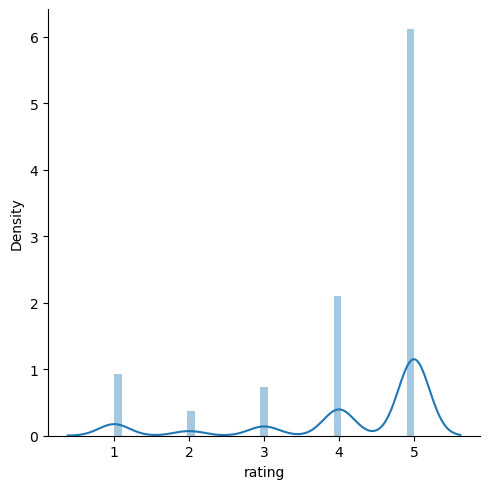

In [63]:
# In other way using histogram 
sns.FacetGrid(data, height=5).map(sns.distplot, "rating")

plt.show()

# mostly rating lies in 4 to 5 range 

#### Infer: approx 60 percent ratings flipkart got for that particular product is 5.

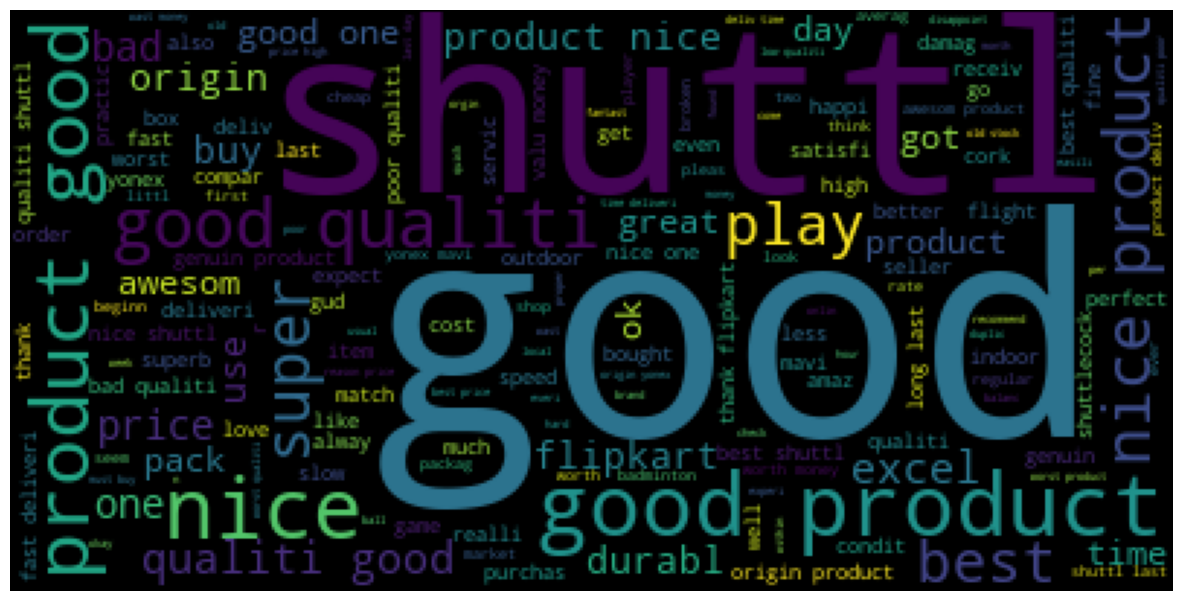

In [64]:
text=" ".join(i for i in data.review)
wordcloud= WordCloud(stopwords=stopwords).generate(text)
plt.figure(figsize=(15, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


###  Infer: 
#### The more the size of word, the more times that are in the reviews.
####  We can see that both good and headphon are the two words which are big in size. So it tells that many people have given review that headphones are good.

In [65]:
# Analysing the scores of reviews to be positive, negative and neutral

nltk.download('vader_lexicon')
sentiment=SentimentIntensityAnalyzer()

data['Positive']=[sentiment.polarity_scores(i)['pos'] for i in data.review]
data['Negative']=[sentiment.polarity_scores(i)['neg'] for i in data.review]
data['Neutral']=[sentiment.polarity_scores(i)['neu'] for i in data.review]
data.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\neera\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\neera\AppData\Local\Temp\ipykernel_23788\1963865354.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\1963865354.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\1963865354.py:8: SettingWithCopyWarning:


A value is trying to be s

,review,rating,Positive,Negative,Neutral
0,nice product good qualiti price rise bad sign ...,4,0.519,0.109,0.373
1,suppli yonex mavi outsid cover yonex ad insid...,1,0.000,0.237,0.763
2,worst product damag shuttlecock pack new box o...,1,0.000,0.378,0.622
3,quit k nowaday qualiti cork like year back...,3,0.355,0.000,0.645
4,pricedjust retaileri understand wat advantag ...,1,0.000,0.000,1.000


In [66]:
x= sum(data['Positive'])
y= sum(data['Negative'])
z= sum(data['Neutral'])

In [67]:
# reviews having negative sentiments more than 10 percent to find reason for the bad feedback
data_safe[data['Negative']>0.10]

,review,rating
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
17,"Poor quality, not originalREAD MORE",2
23,"Looked like defective once, without balance, h...",1
...,...,...
8484,Why can't I order 3 or 4 boxes together. When ...,5
8486,Shuttle is perfect and seems to be durable but...,5
8490,Poor customer service. The delivery boy can't ...,1
8503,Wrost and duplicate productDon't buy this sell...,1


In [68]:

def max_sentiment_score(x, y, z):
    if(x>y and x>z):
        return 'Positive'
    elif (y>x and y>z):
        return 'Negative'
    else:
        return 'Neutral'
    
max_sentiment_score(x, y, z)

'Positive'

#### Infer: Maximum Sentiment Score is 'Neutral '. It means that if we will add up the sentiment effect of reviews on the people, it will not impact positive on the person surely. It can affect positive or negative acccording to the comments, he/she is reading.

### Model Training

In [69]:
data['Output']=np.where((data['Positive']+data['Neutral']>0.80), 'Happy', 'Unhappy')
data.head()

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\2576036477.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review,rating,Positive,Negative,Neutral,Output
0,nice product good qualiti price rise bad sign ...,4,0.519,0.109,0.373,Happy
1,suppli yonex mavi outsid cover yonex ad insid...,1,0.000,0.237,0.763,Unhappy
2,worst product damag shuttlecock pack new box o...,1,0.000,0.378,0.622,Unhappy
3,quit k nowaday qualiti cork like year back...,3,0.355,0.000,0.645,Happy
4,pricedjust retaileri understand wat advantag ...,1,0.000,0.000,1.000,Happy


In [70]:
#!pip install seaborn --upgrade
#pip install matplotlib --upgrade
#pip install pandas --upgrade

In [71]:
data['Output'].dtype

dtype('O')

In [72]:
data['Output'] = data['Output'].astype(str)

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\3126458484.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
data['Output'].fillna('Missing', inplace=True)


C:\Users\neera\AppData\Local\Temp\ipykernel_23788\1100559795.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
print(data['Output'].nunique())


2


In [75]:
print(data['Output'].unique())


['Happy' 'Unhappy']


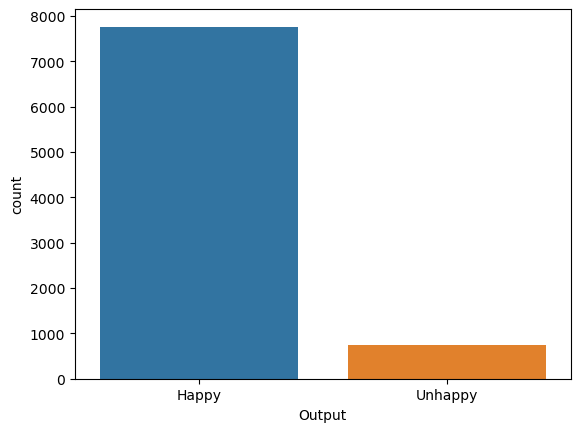

In [76]:
sns.countplot(x=data['Output'])
plt.show()

In [77]:
# is data balanced?

#sns.countplot(data['Output'])

#### Infer: We can see that our data is imbalanced so that if we will train our data, it will be trained inaccurately.



In [78]:
data['Output']=np.where(data['rating']>4, 'Happy', 'Unhappy')

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\688990999.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



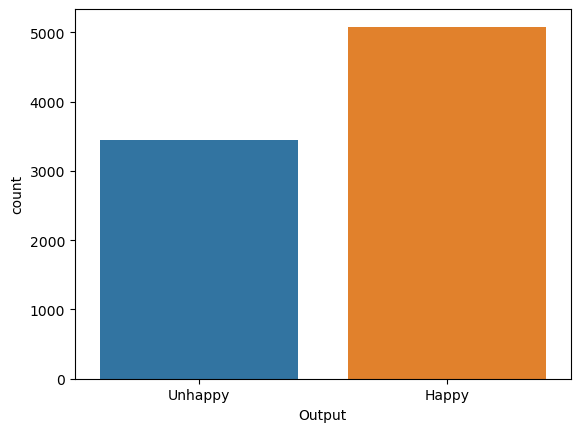

In [79]:
sns.countplot(x=data['Output'])
plt.show()

In [80]:
# Now, is data balanced?

#sns.countplot(data['Output'])

#### Wooh!, Yes Now data is more balanced than before.

#### Good to go

In [81]:
data["Character Counts"]=[len(i) for i in data.review]
data

C:\Users\neera\AppData\Local\Temp\ipykernel_23788\3092409085.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review,rating,Positive,Negative,Neutral,Output,Character Counts
0,nice product good qualiti price rise bad sign ...,4,0.519,0.109,0.373,Unhappy,110
1,suppli yonex mavi outsid cover yonex ad insid...,1,0.000,0.237,0.763,Unhappy,65
2,worst product damag shuttlecock pack new box o...,1,0.000,0.378,0.622,Unhappy,105
3,quit k nowaday qualiti cork like year back...,3,0.355,0.000,0.645,Unhappy,176
4,pricedjust retaileri understand wat advantag ...,1,0.000,0.000,1.000,Unhappy,65
...,...,...,...,...,...,...,...
8513,nan,5,0.000,0.000,1.000,Happy,3
8514,nan,2,0.000,0.000,1.000,Unhappy,3
8515,nan,4,0.000,0.000,1.000,Unhappy,3
8516,nan,1,0.000,0.000,1.000,Unhappy,3


In [82]:
data["Word Counts"]=[len(i.split()) for i in data.review]
data

,review,rating,Positive,Negative,Neutral,Output,Character Counts,Word Counts
0,nice product good qualiti price rise bad sign ...,4,0.519,0.109,0.373,Unhappy,110,19
1,suppli yonex mavi outsid cover yonex ad insid...,1,0.000,0.237,0.763,Unhappy,65,11
2,worst product damag shuttlecock pack new box o...,1,0.000,0.378,0.622,Unhappy,105,15
3,quit k nowaday qualiti cork like year back...,3,0.355,0.000,0.645,Unhappy,176,30
4,pricedjust retaileri understand wat advantag ...,1,0.000,0.000,1.000,Unhappy,65,9
...,...,...,...,...,...,...,...,...
8513,nan,5,0.000,0.000,1.000,Happy,3,1
8514,nan,2,0.000,0.000,1.000,Unhappy,3,1
8515,nan,4,0.000,0.000,1.000,Unhappy,3,1
8516,nan,1,0.000,0.000,1.000,Unhappy,3,1


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review            8518 non-null   object 
 1   rating            8518 non-null   int64  
 2   Positive          8518 non-null   float64
 3   Negative          8518 non-null   float64
 4   Neutral           8518 non-null   float64
 5   Output            8518 non-null   object 
 6   Character Counts  8518 non-null   int64  
 7   Word Counts       8518 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 532.5+ KB


In [84]:
data.describe()

,rating,Positive,Negative,Neutral,Character Counts,Word Counts
count,8518.000000,8518.000000,8518.000000,8518.000000,8518.000000,8518.000000
mean,4.181028,0.565727,0.051946,0.381505,19.933787,3.357596
std,1.262200,0.385898,0.177287,0.354705,24.978127,3.923640
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.098000,0.000000,0.000000,5.000000,1.000000
50%,5.000000,0.737000,0.000000,0.263000,12.000000,2.000000
75%,5.000000,1.000000,0.000000,0.604000,24.000000,4.000000
max,5.000000,1.000000,1.000000,1.000000,323.000000,48.000000


In [85]:
data.to_csv("data_new.csv")

Text(0.5, 1.0, 'Character Counts vs Word Counts of reviews with categorical variable of Output')

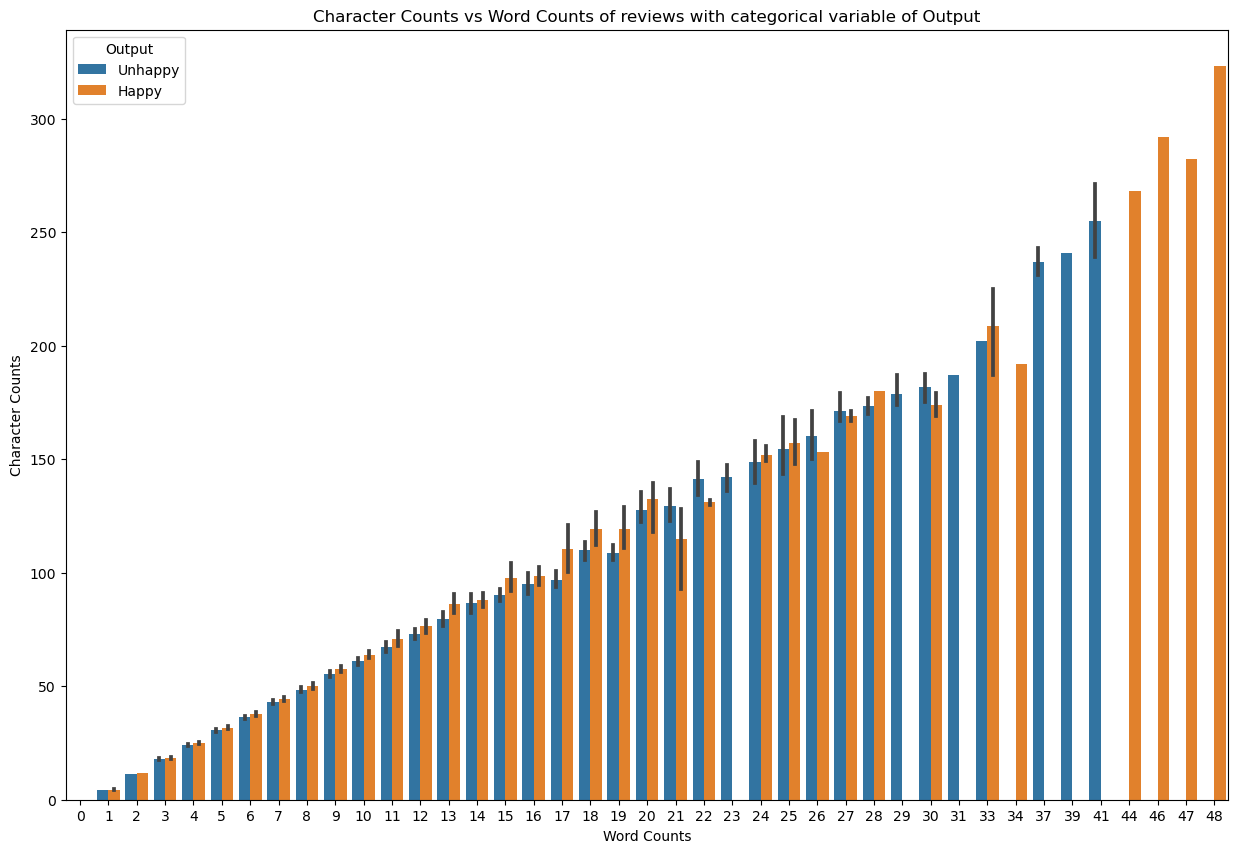

In [86]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Word Counts', y='Character Counts', hue='Output', data=data)
plt.title('Character Counts vs Word Counts of reviews with categorical variable of Output')

Text(0.5, 1.0, 'Output vs Word Counts of reviews')

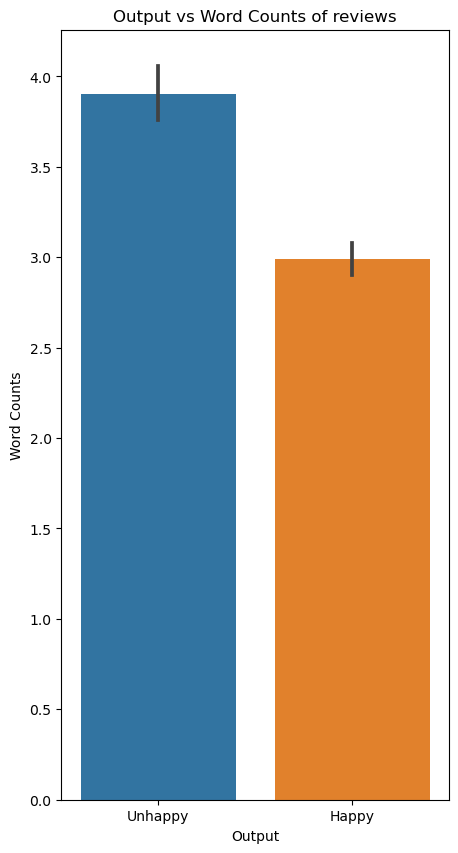

In [87]:
plt.figure(figsize=(5, 10))
sns.barplot(x='Output', y='Word Counts', data=data)
plt.title('Output vs Word Counts of reviews')

#### Infer: Both unhappy and happy ones have written same number of words approximately.

In [88]:
from sklearn.model_selection import train_test_split

Independent_var=data.review
dependent_var=data.Output

ID_train, ID_test, D_train, D_test=train_test_split(Independent_var, dependent_var, test_size=0.3 )

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidfvector=TfidfVectorizer()
classifier=LogisticRegression(solver="lbfgs")

from sklearn.pipeline import Pipeline

model=Pipeline([('vectorizer', tfidfvector), ('classifier', classifier)])
model.fit(ID_train, D_train)


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
predictions=model.predict(ID_test)
print(confusion_matrix(predictions, D_test))
print("Accuracy of the model: ", accuracy_score(D_test, predictions))
print("Precision of the model: ", precision_score(D_test, predictions, average=None))
print("Recall of the model: ", recall_score(D_test, predictions, average=None))
print("F Score of the model: ", f1_score(D_test, predictions, average=None))

[[1401  594]
 [ 131  430]]
Accuracy of the model:  0.7163536776212832
Precision of the model:  [0.70225564 0.76648841]
Recall of the model:  [0.91449086 0.41992188]
F Score of the model:  [0.79444287 0.54258675]


In [90]:
# zipped_data=zip(list(np.array(ID_train)), list(np.array(D_test)), list(predictions))
# for i, j, k in zipped_data:
#     print("Review: ", i)
#     print("Target:  ",j)
#     print("Prediction: ",k)
#     print()
    